# pySED calculates the spectral energy density (SED) for MoS$_2$

This tutorial will show how to use pySED to study the spectral energy density for bulk MoS$_2$ in the out-of-plane and perform the Lorentz fitting.

In addition, this tutorial will use [GPUMD+NEP](https://gpumd.org/) to get molecular dynamics trajectories + velocities, and then pySED to process them to get SED.

Users may need to familiarize themselves with [GPUMD](https://gpumd.org/) software and [NEP](https://gpumd.org/nep/index.html) machine learning potential.

## Installation
In order to install pySED, it is recommended to refer here to install from the [source code](https://github.com/Tingliangstu/pySED?tab=readme-ov-file#installation-instructions).

With that installed, now let's first import the necessary packages to generate the simulation structure.

## Generate supercell structure for GPUMD simulation

In [1]:
from pySED.structure import generate_data

file_name = 'POSCAR_MoS2'        # Triclinic primitive structure of MoS2 with POSCAR format

supercell = (12, 12, 16)         # The number of supercells in the xyz direction

# Generate a structure class
structure = generate_data.structure_maker(structure_file_name=file_name)

# Generate supercell
structure.replicate_supercell(supercell=supercell)

# Write xyz files for gpumd
structure.write_xyz(filename='model.xyz', pbc="T T T")

# Write basis.in files for further used
structure.write_lattice_basis_file()



********************* Reading From VASP POSCAR structure *********************

************* model.xyz is written successfully ************

************* basis.in is written successfully ************



Now we have generated the GPUMD simulation so we have the [model.xyz](https://gpumd.org/gpumd/input_files/model_xyz.html) file and the base.in file that records the mapping between the protocell and the supercell.

Take a look at the contents of basis.in:

In [2]:
with open('basis.in', 'r') as file:
    for _ in range(9):
        print(file.readline())

Create LAMMPS or GPUMD data for SED method by using pySED Codes

atoms_ids unitcell_index basis_index mass_types

1 1 1  95.960000

2 1 2  95.960000

3 1 3  32.065000

4 1 4  32.065000

5 1 5  32.065000

6 1 6  32.065000

7 2 1  95.960000



There are four columns in the basis. 
The first column is the number ID in the supercell, 
the second column is the index of the number of primitive cells, 
the third column is the number of the corresponding basis atom in the supercell, 
and the fourth column is the corresponding mass of the corresponding basis atom.
You can also manually generate this "basis.in" file.

## GPUMD run
After [model.xyz](https://gpumd.org/gpumd/input_files/model_xyz.html) is generated, we can use GPUMD to generate the trajectory and velocity required for pySED. Here is a [run.in](https://gpumd.org/gpumd/input_files/run_in.html) template.

For the required [nep.txt](https://gpumd.org/nep/output_files/nep_txt.html#index-0), you can fit it yourself or use what we provide.

In [3]:
%%writefile run.in

potential      nep.txt

dftd3          pbe  12  6
    
velocity       300

ensemble       npt_scr 300 300 100 0 0 0 0 0 0 20 20 20 20 20 20 1000
time_step      1
dump_thermo    10000
dump_position  100000
run            1000000

######### Nose-Hoover ###############
ensemble       nvt_nhc   300    300   100
time_step      1
dump_thermo    20000
dump_position  50000
run            500000

ensemble       nve
dump_exyz      50     1            # Ten steps output a coordinate and velocity file
run            500000


Overwriting run.in


When GPUMD is finished running, a [dump.xyz](https://gpumd.org/gpumd/input_parameters/dump_exyz.html#dump-exyz) file is output from which pySED can be run.

## pySED calculations

For now, we need to prepare an `input_SED.in` file.

In [4]:
%%writefile input_SED.in
### ************ MD simulation parameters **************
num_atoms = 13824                   # number of atoms in structure
total_num_steps = 500000            # MD simulation steps
time_step = 1                       # Femtoseconds (fs)
output_data_stride = 50             # Data only output every 32 steps in the GPUMD simulation, see the input file.

### ************ Divide up the data for averaging **************
num_splits = 5                      # Number of blocks to average.

### ************ Deal the GPUMD dump velocity file or not **************
compress = 1                        # It would save disk memory

### ************ Input and output files **************
out_files_name = 'bulk_MoS2'
basis_lattice_file = 'basis.in'
dump_xyz_file = 'dump.xyz'                     # output from gpumd
output_hdf5 = 'vel_pos_compress.hdf5'
file_format  = 'gpumd'                         # Now, it support 'lammps' or 'gpumd'

### ************** For multi-thread *****************
use_parallel = 1                  # 0 Disable multithreading. 1 Enable multithreading. On windows, 0 is recommended 
max_cores = 4                     # The number of cores used by multiple threads. Note that the more cores, the greater the memory overhead

### ************ Crystal lattice ************
prim_unitcell = 3.11905 0 0 -1.55952 2.70117 0 0 0 12.6227   # one can check it use ovito (POSCAR)
supercell_dim = 12 12 16             # supercell dimension for MD simulations (the larger supercell, the more q points, automatic determination)
rescale_prim = 1                     # Reconstructed primitive unit cell from MD simulation cell if one use NPT

### ************  Q-points info ************
num_qpaths = 1                     	 # number of dispersion paths to include (if num_qpaths=1, only read one q_path)
q_path_name = 'GA'                   # q-point path name, used for plotting 
q_path = 0.0 0.0 0.0  0.0 0.0 0.5
# end points of the dispersion path in red. reciprocal coords.

# ************ Will look for output files and plot them, then exit ************
# (Tips: plot_SED = 1 means one already have SED data exist, if not, firstly set the plot_SED = 0 to run SED)
plot_SED = 0                        # plot the dispersion (Set to 0 to calculate SED--run SED mode, set 1 to plot and fitting mode)
plot_cutoff_freq = 2.0              # if not set, SED will plot all-range frequency according the FFT, if set frequency will cutoff (THz)
plot_interval = 0.5                 # For a good look SED picture, interval for y-axis (default = 5 THz)
qpoint_slice_index = 0              # the q-point to plot (starts from 0 thanks to python slicing...)
plot_slice = 1                      # plot a q-slice yes or not, according to qpoint_slice_index (bool)
if_show_figures = 0                 # Shows figures for eyes

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html (see the usage)
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html (find peak usage for peak_height and peak_prominence)
# ************ Do Lorentz fitting ************
lorentz = 1                        # whether to fit peaks (if set lorentz_fit_all_qpoint = 1, lorentz = 1 must set)
lorentz_fit_cutoff = 2             # if not set, lorentz fitting figure will plot all-range frequency according the FFT, if set frequency will cutoff (THz), one can set plot_cutoff_freq = lorentz_fit_cutoff (maybe very useful for some strong anharmonicity systems)
peak_height = 1.0e-6               # The lowest height of Lorenz fitting (scipy.signal.find_peaks) -- Important
peak_prominence = 1.0e-7           # A minimal prominence of 9.0e-5
initial_guess_hwhm = 0.0005        # The maximum half height width of the Lorentz fit, which is very useful for some peaks where the fit fails (default=0.01)
re_output_total_freq_lifetime = 0  # This parameter allows you to re-adjust the single peak of a single q point and re-output the TOTAL phonon lifetime (set lorentz_fit_all_qpoint=0)

# ************ Do Lorentz fitting for all q points************
lorentz_fit_all_qpoint = 0         # Fit all qpoints peak and output the phonon lifetime for the systems in the unit of ps


Overwriting input_SED.in


It is recommended to read the `pySED -h` output  carefully and then understand the meaning of the parameters. Each parameter is very simple, if you really do not understand can carefully read the comments or email developer.

Now we can run pySED to perform SED calculations. Let's start by importing some of the necessary modules.

In [5]:
# Necessary modules
import sys
import os
from pySED import (My_Parsers,
                   Compressor,
                   construct_BZ,
                   Phonon,
                   FileIO,
                   Plot_SED,
                   Lorentz)

After you give the necessary MD simulation parameters to `input_SED.in`, mainly change the following parameters.

pySED has three modes. 

1. The first is to compute the SED data by setting the parameter `plot_SED = 0` in `input_SED.in`.

2. The second mode is SED drawing and fitting mode. When you finish calculating in the first mode, you can start the second mode by setting `plot_SED = 1`.

3. The third model is the complete fit model. The second mode gives a fit for a Q-point (if you set `qpoint_slice_index= xx`). With this Q-point fit, you can legitimately set the `peak_height` and `peak_prominence` parameters. So that pySED can correctly identify the peaks of SED.

   Setting `lorentz_fit_all_qpoint = 1` at this time can enter the third mode, which fully fits all peaks at all q points and outputs a file containing phonon lifetimes (`TOTAL-LORENTZ-Qpoints.Fre_lifetime`).

### Now let's go into the first mode (SED running mode)

In [6]:
### **************** Read the input parameter file and get the control parameters ******************
params = My_Parsers.get_parse_input('input_SED.in')

print('\n******************* You are in the SED-Computing mode ********************')

# print(params.output_hdf5 + ' file already exists, and there is no need to compression !!')
if os.path.exists(params.output_hdf5):
   print('\n*************** ' + params.output_hdf5 + ' file will be used ! ****************')
else:
   Compressor.compress(params)
   print('\n******** Compress the velocity and position data to hdf5 is DONE! ********')


******************* You are in the SED-Computing mode ********************

*************** vel_pos_compress.hdf5 file will be used ! ****************


After this step, we compress `dump.xyz` into the `vel_pos_compresse.hdf5` file. We can reuse it later. Let's continue to compute the SED data.

In [7]:
# ***************************** For implement SED Method *******************************
## Construct BZ
BZ_lattice_info = construct_BZ.BZ_methods(params)

## compute SED
phonons = Phonon.spectral_energy_density(params)
phonons.compute_sed(params, BZ_lattice_info)

### Save the data to output files
FileIO.write_output(phonons, params, BZ_lattice_info)

print('\n********** SED-Computing mode is running done for all Q-points, Now you can run plotting mode **********\n')


************************** Structural information *****************************
Primitive unit cell matrix is (Angstrom):
   3.11905000e+00     0.00000000e+00     0.00000000e+00
  -1.55952000e+00     2.70117000e+00     0.00000000e+00
   0.00000000e+00     0.00000000e+00     1.26227000e+01

MD simulation cell matrix is (Angstrom):
   3.79231354e+01     4.53051190e-01     6.22232170e-01
  -1.94036426e+01     3.26161485e+01    -5.24530400e-02
  -3.29413588e+00    -1.75992632e+00     1.94014241e+02

⚠️Warning⚠️: The cell matrix in the trajectory is different from calculated by the primitive cell and supercell dimensions.
This suggests that structural optimization is likely performed using the NPT ensemble.

Now, pySED have reconstructed primitive unit cell matrix from MD simulation cell (Angstrom):
   3.16026129e+00     3.77542658e-02     5.18526808e-02
  -1.61697022e+00     2.71801238e+00    -4.37108667e-03
  -2.05883492e-01    -1.09995395e-01     1.21258901e+01

************************

After completing this calculation, you have the SED data in the current folder. Here we have three files: 
`bulk_MoS2.SED`, `bulk_MoS2.Qpt`s, `bulk_MoS2.THz`, which respectively represent the SED data of all q points, the q data of Brillouin zone and the corresponding frequency data.

With this data, people can also draw their own pictures. Drawing scripts are also available in the [pySED toolkit](https://github.com/Tingliangstu/pySED/tree/main/tools).
Let's use pySED's built-in features to draw a picture.

### pySED's drawing mode.



Users may vary the `initial_guess_hwhm` parameter to explore how it influences the fitting performance


***** You are in the single SED-qpoint plotting mode, plot SED for single Q-point *****

You are using "imshow" method for SED plotting since single Qpaths, it can be change to "contourf" by setting "use_contourf = 1" in the input.in.


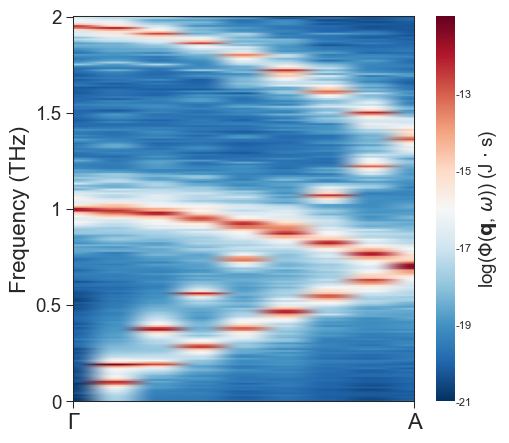

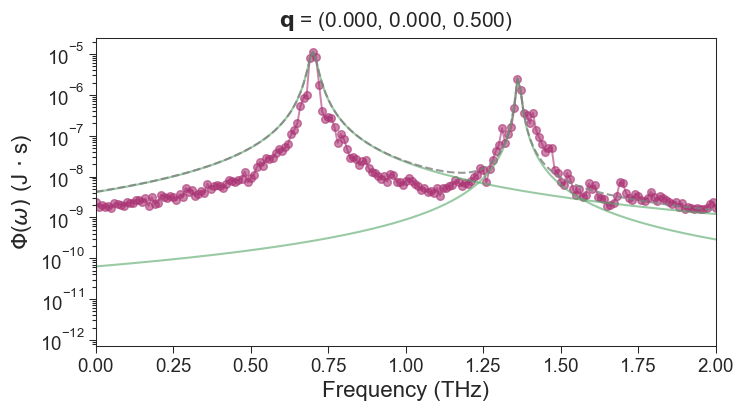

In [17]:
print('\n***** You are in the single SED-qpoint plotting mode, plot SED for single Q-point *****\n')
data = FileIO.load_data(params)
Plot_SED.plot_bands(data, params)
Plot_SED.plot_slice(data, params)

### All fitting mode
We can easily visualize the SED plot with a corresponding q point. From this we can determine `peak_height` and `peak_prominence`. These two represent the highest peak and peak height of the SED peak respectively. see the [scipy usage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html) for details.

Here we set `peak_height = 1.0e-6` and `peak_prominence = 1.0e-7` in the `input_SED.in`, and then enter the phonon lifetime fit mode.


************************* You are in the ALL plotting mode !!! ************************

***************************************************************************************
***************** Now processing 0-th Qpoint SED Lorentz fitting **********************
***************** ⚠️WARNING: Now the Frequency will cutoff to 2.000 *******************

*** Found 2 peaks in the SED-0-th qpoint curve, Please compare with the actual peak ***

**** Peaks is as follows, one can tune fitting paras according them ****:
Frequency: [1.   1.95] THz

Peak_height: [6.38002905e-06 4.15731661e-06] J*s

************** LORENTZ-0-th Qpoints.Fre_lifetime is written successfully **************

**** The fitting hwhm is [0.00854204 0.00643231], Please check it. ****


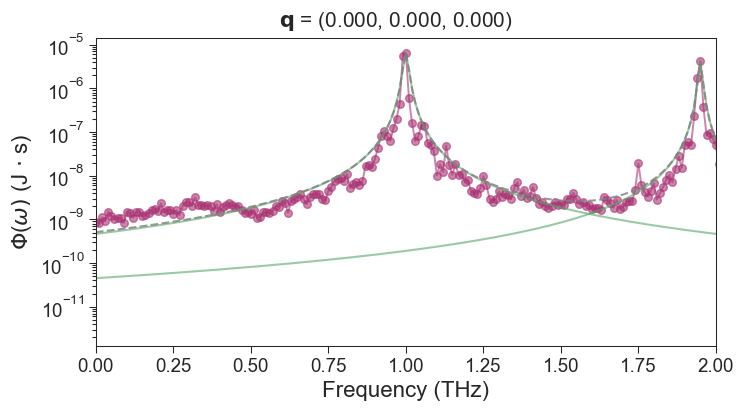

***************************************************************************************
***************** Now processing 1-th Qpoint SED Lorentz fitting **********************
***************** ⚠️WARNING: Now the Frequency will cutoff to 2.000 *******************

*** Found 4 peaks in the SED-1-th qpoint curve, Please compare with the actual peak ***

**** Peaks is as follows, one can tune fitting paras according them ****:
Frequency: [0.1  0.19 0.99 1.94] THz

Peak_height: [4.88477048e-06 1.33402126e-05 4.30076207e-06 6.58932621e-06] J*s

************** LORENTZ-1-th Qpoints.Fre_lifetime is written successfully **************

**** The fitting hwhm is [0.00650746 0.00315679 0.00933333 0.00329322], Please check it. ****


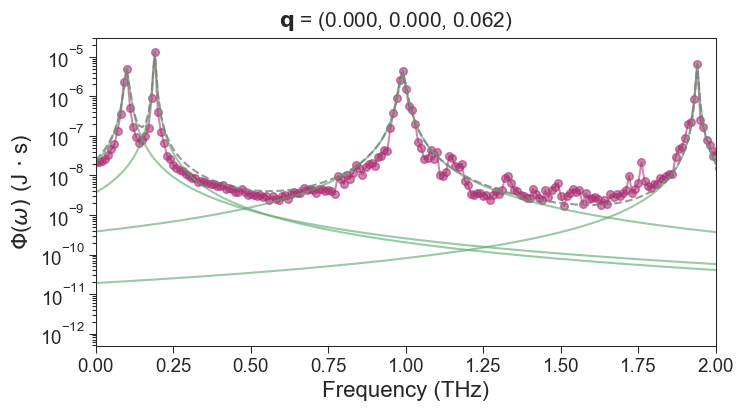

***************************************************************************************
***************** Now processing 2-th Qpoint SED Lorentz fitting **********************
***************** ⚠️WARNING: Now the Frequency will cutoff to 2.000 *******************

*** Found 4 peaks in the SED-2-th qpoint curve, Please compare with the actual peak ***

**** Peaks is as follows, one can tune fitting paras according them ****:
Frequency: [0.19 0.37 0.98 1.91] THz

Peak_height: [2.97331218e-06 6.41679294e-06 5.96412067e-06 3.11774377e-06] J*s

************** LORENTZ-2-th Qpoints.Fre_lifetime is written successfully **************

**** The fitting hwhm is [0.00558741 0.00670279 0.00822115 0.00426688], Please check it. ****


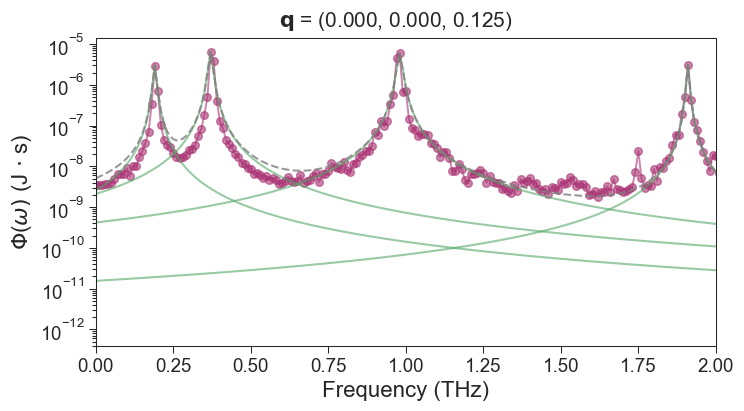

***************************************************************************************
***************** Now processing 3-th Qpoint SED Lorentz fitting **********************
***************** ⚠️WARNING: Now the Frequency will cutoff to 2.000 *******************

*** Found 4 peaks in the SED-3-th qpoint curve, Please compare with the actual peak ***

**** Peaks is as follows, one can tune fitting paras according them ****:
Frequency: [0.28 0.56 0.95 1.86] THz

Peak_height: [3.93798142e-06 5.44820641e-06 3.08188017e-06 3.31557148e-06] J*s

************** LORENTZ-3-th Qpoints.Fre_lifetime is written successfully **************

**** The fitting hwhm is [0.00693663 0.00339702 0.01014802 0.00330869], Please check it. ****


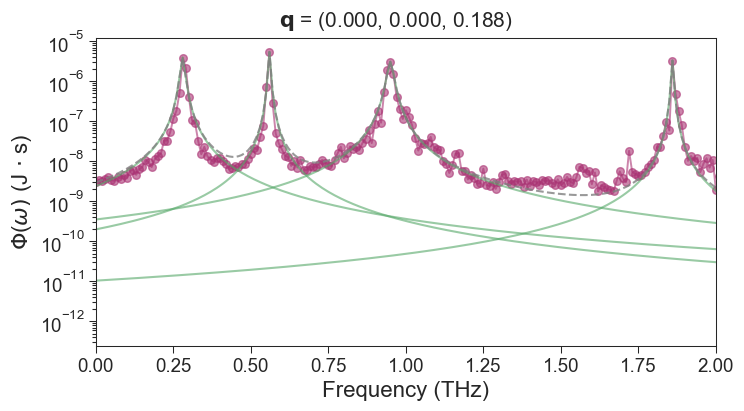

***************************************************************************************
***************** Now processing 4-th Qpoint SED Lorentz fitting **********************
***************** ⚠️WARNING: Now the Frequency will cutoff to 2.000 *******************

*** Found 4 peaks in the SED-4-th qpoint curve, Please compare with the actual peak ***

**** Peaks is as follows, one can tune fitting paras according them ****:
Frequency: [0.38 0.73 0.92 1.8 ] THz

Peak_height: [2.45617992e-06 1.56104593e-06 4.63135656e-06 1.37557155e-06] J*s

************** LORENTZ-4-th Qpoints.Fre_lifetime is written successfully **************

**** The fitting hwhm is [0.00859183 0.00954785 0.0100381  0.0062082 ], Please check it. ****


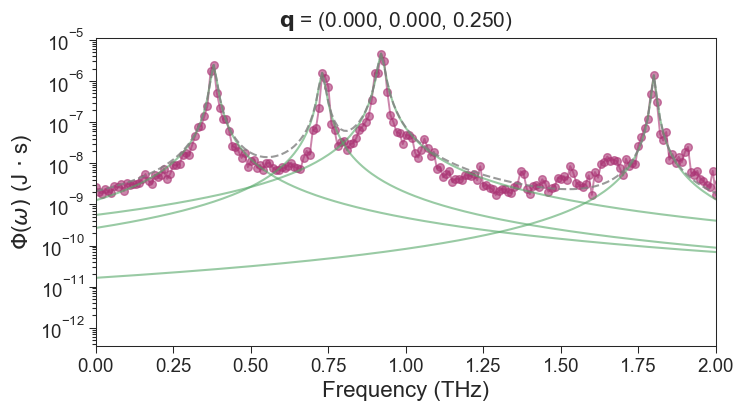

***************************************************************************************
***************** Now processing 5-th Qpoint SED Lorentz fitting **********************
***************** ⚠️WARNING: Now the Frequency will cutoff to 2.000 *******************

*** Found 3 peaks in the SED-5-th qpoint curve, Please compare with the actual peak ***

**** Peaks is as follows, one can tune fitting paras according them ****:
Frequency: [0.46 0.87 1.72] THz

Peak_height: [5.21098860e-06 5.56207258e-06 4.47810082e-06] J*s

************** LORENTZ-5-th Qpoints.Fre_lifetime is written successfully **************

**** The fitting hwhm is [0.0095208  0.00666231 0.00544267], Please check it. ****


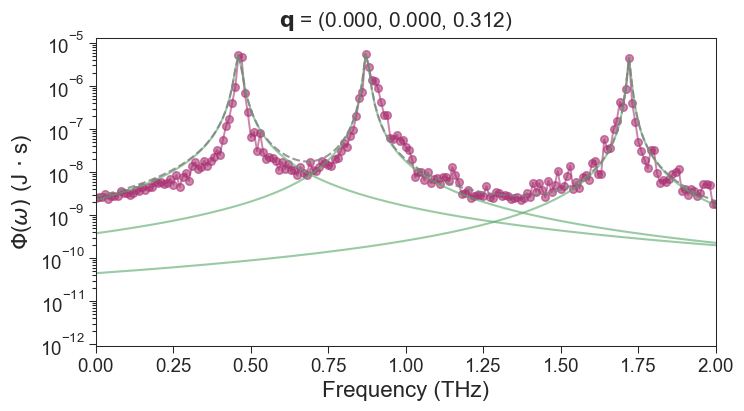

***************************************************************************************
***************** Now processing 6-th Qpoint SED Lorentz fitting **********************
***************** ⚠️WARNING: Now the Frequency will cutoff to 2.000 *******************

*** Found 4 peaks in the SED-6-th qpoint curve, Please compare with the actual peak ***

**** Peaks is as follows, one can tune fitting paras according them ****:
Frequency: [0.55 0.82 1.07 1.61] THz

Peak_height: [2.41737792e-06 5.41500687e-06 4.34315143e-06 1.72847247e-06] J*s

************** LORENTZ-6-th Qpoints.Fre_lifetime is written successfully **************

**** The fitting hwhm is [0.00612624 0.0080166  0.00517217 0.00830124], Please check it. ****


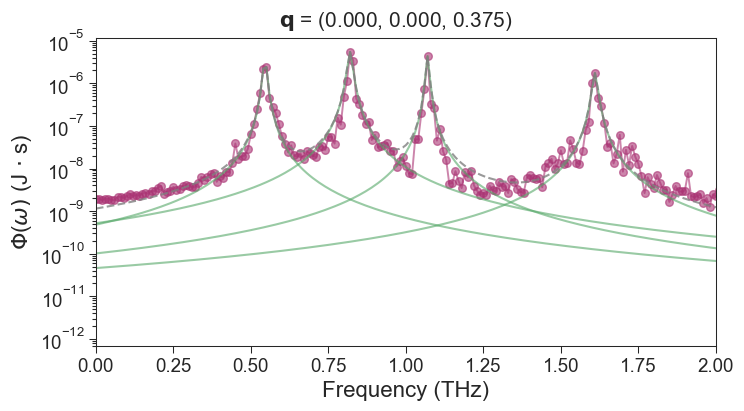

***************************************************************************************
***************** Now processing 7-th Qpoint SED Lorentz fitting **********************
***************** ⚠️WARNING: Now the Frequency will cutoff to 2.000 *******************

*** Found 4 peaks in the SED-7-th qpoint curve, Please compare with the actual peak ***

**** Peaks is as follows, one can tune fitting paras according them ****:
Frequency: [0.63 0.76 1.22 1.5 ] THz

Peak_height: [3.74267519e-06 5.88208327e-06 2.10504480e-06 4.83457866e-06] J*s

************** LORENTZ-7-th Qpoints.Fre_lifetime is written successfully **************

**** The fitting hwhm is [0.00531414 0.00981738 0.00501961 0.00579586], Please check it. ****


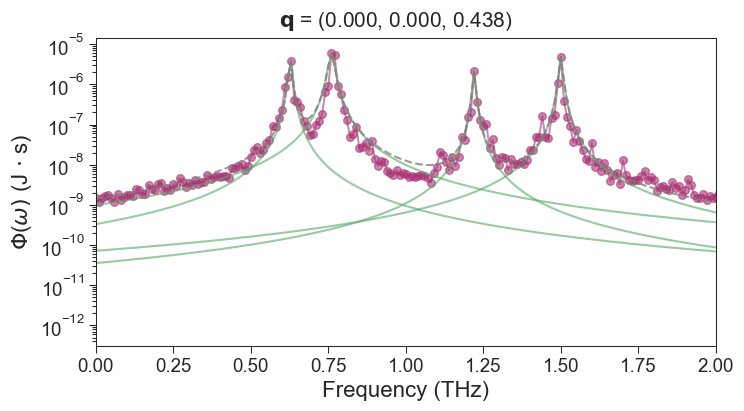

***************************************************************************************
***************** Now processing 8-th Qpoint SED Lorentz fitting **********************
***************** ⚠️WARNING: Now the Frequency will cutoff to 2.000 *******************

*** Found 2 peaks in the SED-8-th qpoint curve, Please compare with the actual peak ***

**** Peaks is as follows, one can tune fitting paras according them ****:
Frequency: [0.7  1.36] THz

Peak_height: [1.12200082e-05 2.49466333e-06] J*s

************** LORENTZ-8-th Qpoints.Fre_lifetime is written successfully **************

**** The fitting hwhm is [0.01346946 0.00620709], Please check it. ****


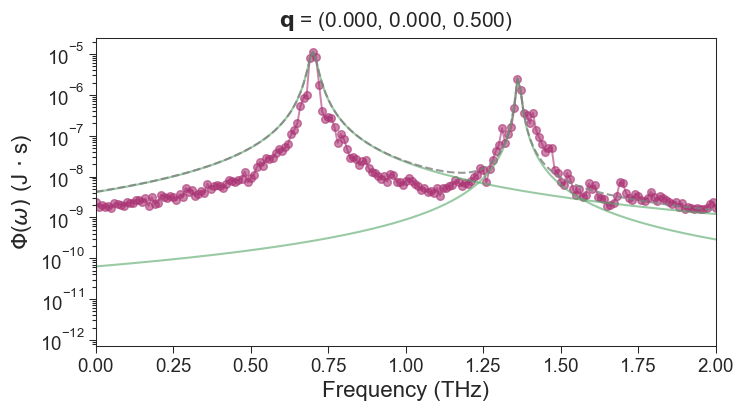


**** TOTAL-LORENTZ-Qpoints.Fre_lifetime is written successfully (Total 31 points) *****

****************************** pySED PLOTTING ALL DONE !!!!! ****************************


In [16]:
params = My_Parsers.get_parse_input('input_SED.in')    # Here we re-read input_SED.in because it may have been modified
data = FileIO.load_data(params)

print('\n************************* You are in the ALL plotting mode !!! ************************\n')
for j in range(len(data.q_distances)):
    # Control parameters for all Qpoints
    params.q_slice_index = j
    params.if_show_figures = True
    params.plot_lorentz = False

    print('***************************************************************************************')
    print('***************** Now processing {}-th Qpoint SED Lorentz fitting **********************'.format(j))
    data = FileIO.load_data(params)
    Lorentz.lorentz(data, params)
    
FileIO.deal_total_fre_lifetime(params, len(data.q_distances))
print('\n****************************** pySED PLOTTING ALL DONE !!!!! ****************************')

Through the fitting mode, we can see that pySED finds all the peaks and performs Lorentz fits on them. The fitting results is also OK. The `TOTAL-LORENTZ-Qpoints.Fre_lifetim`e file is output under the current folder, containing the fitted phonon lifetime of all q points. In addition, the fitting of phonon lifetimes at different q points is also output.

We can plot the phonon lifetime.

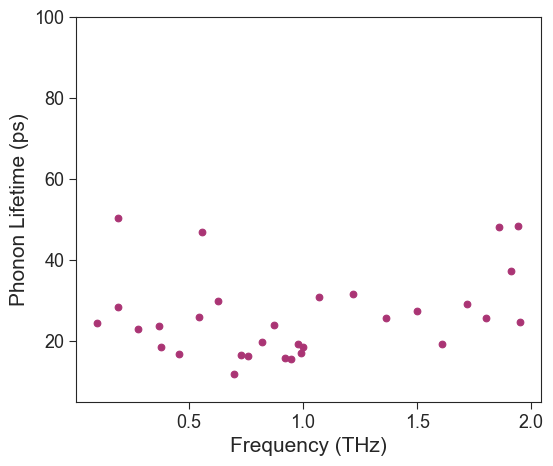

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# *************************** Set Seaborn style for good look *************************
sns.set(style="ticks")
sns.set_context("paper", rc={"axes.linewidth": 0.8, 
                             "xtick.major.width": 0.8, 
                             "ytick.major.width": 0.8,
                             "axes.labelsize": 15, 
                             "xtick.labelsize": 13.0, 
                             "ytick.labelsize": 13.0})
# *************************** Set Seaborn style *************************

# Load data
data = pd.read_csv('TOTAL-LORENTZ-Qpoints.Fre_lifetime', 
                   sep=r'\s+', 
                   
                   comment='#', 
                   header=None, 
                   skiprows=2)
data.columns = ['Frequency (THz)', 'Phonon Lifetime (ps)']

# Plot with log scale on y-axis
plt.figure(figsize=(6, 5))
plt.scatter(data['Frequency (THz)'], data['Phonon Lifetime (ps)'], color="#aa3474")
plt.xlabel('Frequency (THz)')
plt.ylabel('Phonon Lifetime (ps)')
#plt.yscale('log')  
plt.ylim([5, 100])
plt.show()

If you have more q points and more dump data frames, this will look better.

Through the above tutorial, one can get a general idea of pySED's workflow. SED can be computed easily by calling pySED's classes in python.
Currently, the only inconvenience is the need to call the control file `input_SED.in`. 

pySED also provides a command line to run it.
I hope you can enjoy the process.